Suite à la première partie "P1", nous allons continuer notre analyse en rafinant certaines fonctionnalités présentées précédemment et continuer à explorer des nouvelles possibilités d'analyse par les arbres de décisions.


Pour faciliter notre travail, nous avons enregistré dans des nouveaux fichiers csv, les modifications apportées aux datasets train et csv (ajout de colonnes, nettoyage, etc) de manière à ne pas avoir à les refaire dans P2. Le code pour enregistrer ces fichiers a été ajouté à la fin du notebook P1 et consiste en l'utilisation de la fonction pandas.DataFrame.to_csv.



In [10]:
# import de la librairie pandas qui sera appelée par l'acronyme 'pd' dans le corps du code
import pandas as pd

# header = 0 indique la présence de titres sur chaque colonne
dfTrainP2 = pd.read_csv('trainP2.csv', header=0)

# header = 0 indique la présence de titres sur chaque colonne
dfTestP2 = pd.read_csv('testP2.csv', header=0)

Nous allons reprendre notre modèle liénaire et observer les résidus.

r-squared: 0.501905176825 p value: 0.0326631156537 std: 0.301763277766


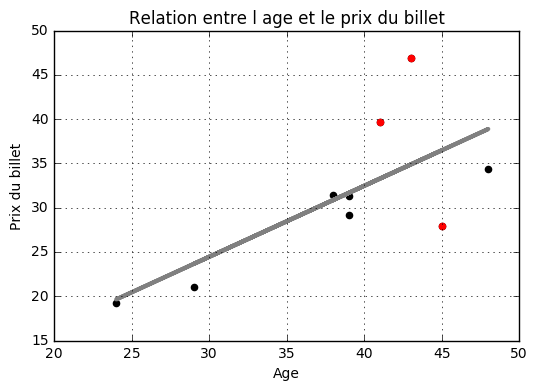

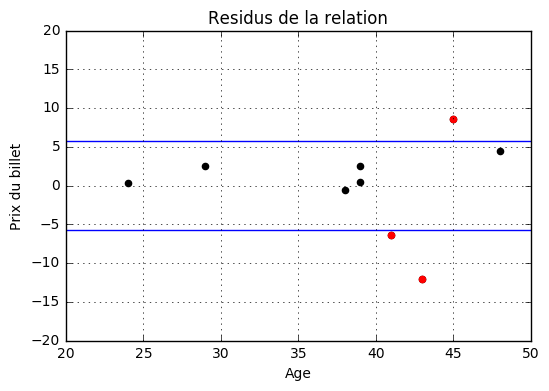

In [72]:
import matplotlib.pyplot as plt

from scipy import stats

dfForLinearRegr = dfTrainP2[ (dfTrainP2['Gender'] == 0) 
                      & (dfTrainP2['AgeFill'] > 18.0) 
                      & (dfTrainP2['Pclass'] == 3.0) 
                      #& (dfTrain['Embarked'] == "S") # cette condition n'est pas présentement testée
                      & (dfTrainP2['Parch'] > 2)
                      & (dfTrainP2['SibSp'] > -1)
                
                     ]

x = dfForLinearRegr["AgeFill"]
y = dfForLinearRegr["Fare"]

slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)

print "r-squared:", r_value**2, "p value:", p_value, "std:", std_err

yFitted = slope*x + intercept 
    
# Visualisation des données
plt.scatter(x, y,  color='black')
plt.scatter(x.values[[1,4,5]], y.values[[1,4,5]],  color='red')
plt.plot(x, yFitted, color='gray', linewidth=3)
plt.title('Relation entre l age et le prix du billet')  
plt.xlabel('Age')  
plt.ylabel('Prix du billet')
plt.grid()
plt.show()

# Calcul des résidus:
res = yFitted- y

# Calcul de la valeur de deviation standard pour les résidus:
stdRes = np.std(yFitted- y)

plt.scatter(x, res,  color='black')
plt.scatter(x.values[[1,4,5]], res.values[[1,4,5]],  color='red')

plt.ylim(-20,20)
plt.title('Residus de la relation')  
plt.xlabel('Age')  
plt.ylabel('Prix du billet')
plt.grid()
plt.axhline(y=stdRes)
plt.axhline(y=-stdRes)
plt.show()


Nous avons calculé la p value du test d'hypothèse que la pente de la régression est égal à zero et nous trouvons une valeur inférieure à 0.05, ce qui nous indique que cette regression est valide à un taux de confiance de 95%.

En revanche, nous observons que certains résidus de cette regression se trouvent en dehors de l'intervalle de confiance que nous avons estimé par le calcul de la déviation standard de ces résidus (lignes continues bleues). Les 3 valeurs du prix du billet associées à ces résidus (points en rouge) semblent donc être moins bien prédites par la regression linéaire et diminuent la puissance de ce modèle pour prédire le prix du billet en fonction de l'age des passagers.

Nous allons reprendre notre modèle logistique et évaluer sa précision.

Entrainement du modèle de regression logistique:

In [12]:
import numpy as np

X_train = dfTrainP2[['Pclass', 'Parch', 'SibSp', 'FareCat','Gender','AgeCat']]
y_train = dfTrainP2['Survived'].reshape(-1, 1)
y_train = np.ravel(y_train)

# Importation du second fichier test.csv pour tester notre modèle logistique
X_test = dfTestP2[['Pclass', 'Parch', 'SibSp', 'FareCat','Gender','AgeCat']]


In [80]:
from sklearn.linear_model.logistic import LogisticRegression

classifier = LogisticRegression()
classifier.fit(X_train, y_train)
predictions = classifier.predict(X_test)

0.808080808081


Pour évaluer le taux de précision de notre modèle logistique, nous allons faire appel à la fonction sklearn.model_selection.cross_val_score qui va attribuer un score sur 100 de la réussite des prédictions du modèle sur une validation croisée de sous-parties du dataset dfTrainP2. Du fait du nombre d'observations limité (< 1000 lignes), nous avons laissé la valeur par défault de la fonction pour déterminer la division en 3 sousparties, ce qui ne devrait pas donner un poids plus important à une souspartie par rapport aux autres dans le succès ou l'échec de la validation du modèle.

In [83]:
from sklearn.model_selection import cross_val_score

print "validation croisée:" ,cross_val_score(classifier, X_train, y_train, cv=3)

print "score regr logistique:",(classifier.score(X_train, y_train))

validation croisée: [ 0.77777778  0.82828283  0.78114478]
score regr logistique: 0.808080808081


Nous voyons des scores qui sont relativement élevés mais insuffisant pour valider notre modèle à un taux de 95% de confiance. Il ya donc une part de variabilité dans la survie des passagers qui n'est pas correctement prédite par le modèle et donc les variables que nous avons fournies au modèle sont insuffisantes ou pas assez déterminantes pour que ce modèle logistique puisse prédire avec une haute précision statistique la survie des passagers. Le calcul du score directement par la fonction score reproduit une valeur comparable à celle obtenue avec la validation croisée.

Nous pouvons essayer un autre algorythme de classification: kNN pour k-nearest neighbors:

In [78]:
# Create and fit a nearest-neighbor classifier
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()
knn.fit(X_train, y_train) 
knn.predict(X_test)
print "knn score:",knn.score(X_train, y_train)

knn score: 0.851851851852


On voit que le score de ce classifieur kNN sur le training dataset est légèrement supérieur par rapport au modèle de regression logistique. Il aurait donc potentiellement une puissance légèrement plus importante pour prédire la survie des passagers.

Nous pouvons également tester un algorythme de "Support vector machines" (SVMs):


In [88]:
from sklearn import svm
svc = svm.SVC(C=1, kernel='linear')

print "svc score:",svc.fit(X_train, y_train).score(X_train, y_train)

svc score: 0.786756453423


Pour l'instant, le score est plutôt bas par rapport aux autres classifieurs mais nous savons que l'algorythme svc possède un paramètre C influant sur la qualité du résultat.

Nous allons donc tenter d'estimer ce paramètre au mieux pour améliorer le score:

F:\Anaconda2\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


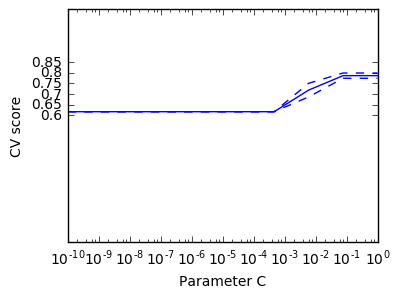

In [90]:
import numpy as np
from sklearn import cross_validation, datasets, svm

svc = svm.SVC(kernel='linear')
C_s = np.logspace(-10, 0, 10)

scores = list()
scores_std = list()
for C in C_s:
    svc.C = C
    this_scores = cross_validation.cross_val_score(svc, X_train, y_train, n_jobs=1)
    scores.append(np.mean(this_scores))
    scores_std.append(np.std(this_scores))

# Do the plotting
import matplotlib.pyplot as plt
plt.figure(1, figsize=(4, 3))
plt.clf()
plt.semilogx(C_s, scores)
plt.semilogx(C_s, np.array(scores) + np.array(scores_std), 'b--')
plt.semilogx(C_s, np.array(scores) - np.array(scores_std), 'b--')
locs, labels = plt.yticks()
plt.yticks(locs, list(map(lambda x: "%g" % x, locs)))
plt.ylabel('CV score')
plt.xlabel('Parameter C')
plt.ylim(0, 1.1)
plt.show()

On voit ici que le score maximal est obtenu lorsque le paramètre C se situe approximativement entre 0.1 et 1. Nous sommes déjà dans cette gamme de valeurs, il n'y a donc pas d'amélioration possible du score SVC par un changement du paramètre C.

Nous pouvons conclure que ces 3 classifieurs (logistique, kNN et SVC) obtiennent dans le cas présent des résultats équivalents avec peu de variations dans leur score de prédiction de la survie des passagers du Titanic. Nous ne pouvons donc pas conseiller l'utilisation d'un outil par rapport à un autre pour obtenir un meilleur résultat.